### Brief inplementatin of the LangGraph

Our solution incorporates a complex LangGraph orchestrated flow, keeping the User interactively in the Loop.

The user provides input, which is then processed by the **Retriever** and checked against a **Prompt Verificator** to determine whether the context is sufficient and relevant. If not, the user is guided to cooperate until a good similarity threshold is met.

If the context is sufficient, the **Writer** drafts a story and sends it to the **Watcher**, who is responsible for monitoring the process, keeping memory of iterations, and interacting with the user.

The Draft is sent to the **Editor**, who checks against storytelling protocols and searches for grammar/lexical mistakes. Multiple loops are executed until the protocols are met.

During contextual and character embedding, different LLM models are used depending on their limit and inference speed. Our Final Editor utilizes a fine-tuned Ollama-serviced BGgpt model aligned with best editor practices.

1. **User Interaction**:
   - The user provides input, such as a request for a story about a specific character or theme.
   - The system may ask for additional personalized details like the main character, environment, or moral/lesson.

2. **Retriever**:
   - The input is processed by the Retriever, which uses a Vector DB with contextual and character LLM-enhanced embeddings.
   - It checks if the context is enough and relevant.

3. **Prompt Verificator**:
   - If the context is not sufficient, the Prompt Verificator checks the similarity threshold and may prompt the user for more information.

4. **Writer**:
   - If the context is sufficient, the Writer drafts a story based on the input.

5. **Watcher**:
   - The Watcher monitors the process, updating the state and allowing for a maximum of three drafts.
   - It interacts with the user if necessary.

6. **Editor**:
   - The draft is checked by the Editor against storytelling protocols and for grammar/lexical mistakes using a BGgpt model serviced by Ollama.

7. **Success**:
   - If the draft passes the checks, the process is marked as successful.

This flowchart outlines a structured approach to generating personalized stories, ensuring quality and relevance through multiple stages of verification and editing.

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain-groq==0.2.0 --progress-bar off
!pip install -qqq langgraph==0.2.22 --progress-bar off

In [ ]:
import sqlite3
import textwrap
from enum import Enum, auto
from typing import List, Literal, Optional, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import userdata
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field

np.random.seed(42)

MODEL = "llama-3.1-70b-versatile"

llm = ChatGroq(temperature=0, model_name=MODEL, api_key=userdata.get("GROQ_API_KEY"))

EDITOR_PROMPT = """
Rewrite for maximum social media engagement:

- Use attention-grabbing, concise language
- Inject personality and humor
- Optimize formatting (short paragraphs)
- Encourage interaction (questions, calls-to-action)
- Ensure perfect grammar and spelling
- Rewrite from first person perspective, when talking to an audience

Use only the information provided in the text. Think carefully.
"""

TWITTER_PROMPT = """
Generate a high-engagement tweet from the given text:
1. What problem does this solve?
2. Focus on the main technical points/features
3. Write a short, coherent paragraph (2-3 sentences max)
4. Use natural, conversational language
5. Optimize for virality: make it intriguing, relatable, or controversial
6. Exclude emojis and hashtags
"""

TWITTER_CRITIQUE_PROMPT = """
You are a Tweet Critique Agent. Your task is to analyze tweets and provide actionable feedback to make them more engaging. Focus on:

1. Clarity: Is the message clear and easy to understand?
2. Hook: Does it grab attention in the first few words?
3. Brevity: Is it concise while maintaining impact?
4. Call-to-action: Does it encourage interaction or sharing?
5. Tone: Is it appropriate for the intended audience?
6. Storytelling: Does it evoke curiosity?
7. Remove hype: Does it promise more than it delivers?

Provide 2-3 specific suggestions to improve the tweet's engagement potential.
Do not suggest hashtags. Keep your feedback concise and actionable.

Your goal is to help the writer improve their social media writing skills and increase engagement with their posts.
"""

# Graph

class Post(BaseModel):
    """A post written in different versions"""

    drafts: List[str]
    feedback: Optional[str]


class AppState(TypedDict):
    user_text: str
    target_audience: str
    edit_text: str
    tweet: Post
    linkedin_post: Post
    n_drafts: int

# Nodes

# Editor
def editor_node(state: AppState):
    prompt = f"""
text:
```
{state["user_text"]}
```
""".strip()
    response = llm.invoke([SystemMessage(EDITOR_PROMPT), HumanMessage(prompt)])
    return {"edit_text": response.content}


# Tweet Writer
def tweet_writer_node(state: AppState):

    post = state["tweet"]

    feedback_prompt = (
        ""
        if not post.feedback
        else f"""
Tweet:
```
{post.drafts[-1]}
```

Use the feedback to improve it:
```
{post.feedback}
```
""".strip()
    )

    prompt = f"""
text:
```
{state["edit_text"]}
```

{feedback_prompt}

Target audience: {state["target_audience"]}

Write only the text for the post
""".strip()

    response = llm.invoke([SystemMessage(TWITTER_PROMPT), HumanMessage(prompt)])
    post.drafts.append(response.content)
    return {"tweet": post}

# Tweet Critique
def critique_tweet_node(state: AppState):
    post = state["tweet"]

    prompt = f"""
Full post:
```
{state["edit_text"]}
```

Suggested tweet (critique this):
```
{post.drafts[-1]}
```

Target audience: {state["target_audience"]}
""".strip()

    response = llm.invoke(
        [SystemMessage(TWITTER_CRITIQUE_PROMPT), HumanMessage(prompt)]
    )
    post.feedback = response.content
    return {"tweet": post}


def supervisor_node(state: AppState):
    return state

# Edges
def should_rewrite(
    state: AppState,
) -> Literal[["tweet_critique"], END]:
    tweet = state["tweet"]
    if len(tweet.drafts) >= n_drafts:
        return END

    return ["tweet_critique"]

graph = StateGraph(AppState)

graph.add_node("editor", editor_node)
graph.add_node("tweet_writer", tweet_writer_node)
graph.add_node("tweet_critique", critique_tweet_node)
graph.add_node("supervisor", supervisor_node)

graph.add_edge("editor", "tweet_writer")

graph.add_edge("tweet_writer", "supervisor")
graph.add_conditional_edges("supervisor", should_rewrite)

graph.add_edge("tweet_critique", "tweet_writer")

graph.set_entry_point("editor")

app = graph.compile()

display(Image(app.get_graph().draw_mermaid_png()))

%%time
config = {"configurable": {"thread_id": 42}}

user_text = """
With 22 billion parameters, Mistral Small v24.09 offers customers a convenient mid-point between Mistral NeMo 12B and Mistral Large 2,
providing a cost-effective solution that can be deployed across various platforms and environments.
The new small model delivers significant improvements in human alignment, reasoning capabilities, and code over the previous model.

Mistral-Small-Instruct-2409 is an instruct fine-tuned version with the following characteristics:

- 22B parameters
- Vocabulary to 32768
- Supports function calling
- 128k sequence length

Mistral Small v24.09 is released under the MRL license. You may self-deploy it for non-commercial purposes, using e.g. vLLM

Weights on HuggingFace hub: https://huggingface.co/mistralai/Mistral-Small-Instruct-2409
"""

state = app.invoke(
    {
        "user_text": user_text,
        "target_audience": "AI/ML engineers and researchers, Data Scientists",
        "tweet": Post(drafts=[], feedback=None),
        "linkedin_post": Post(drafts=[], feedback=None),
        "n_drafts": 3,
    },
    config=config,
)

print(state["tweet"].feedback)

In [ ]:
print(state["edit_text"])

for i, draft in enumerate(state["tweet"].drafts):
    print(f"Draft #{i+1}")
    print("-" * 10)
    print(textwrap.fill(draft, 80))
    print()
print(state["edit_text"])
for i, draft in enumerate(state["tweet"].drafts):
    print(f"Draft #{i+1}")
    print("-" * 10)
    print(textwrap.fill(draft, 80))
    print()

In [7]:
import sqlite3
import textwrap
from enum import Enum, auto
from typing import List, Literal, Optional, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field

np.random.seed(42)

MODEL = "llama-3.1-70b-versatile"
api_key = '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'
llm = ChatGroq(temperature=0, model_name=MODEL, api_key=api_key)

class FairyTaleState(TypedDict):
    user_input: str
    personalized_details: dict
    story_draft: str
    feedback: Optional[str]
    n_drafts: int

class FairyTale(BaseModel):
    drafts: List[str]
    feedback: Optional[str]

WRITER_PROMPT = """
Generate a fairy tale based on the given input and personalized details:
- Incorporate the main character, environment, and moral lesson
- Use vivid, engaging language suitable for the target audience
- Ensure the story has a clear beginning, middle, and end
- Include elements of wonder and magic typical in fairy tales
- Aim for a length of about 500 words
"""

EDITOR_PROMPT = """
Review and improve the fairy tale:
- Check for consistency with the personalized details
- Ensure the story follows the fairy tale structure
- Improve language and pacing
- Enhance character development and world-building
- Strengthen the moral lesson
"""

WATCHER_PROMPT = """
Analyze the fairy tale and provide feedback:
1. Engagement: Is the story captivating from the beginning?
2. Character development: Are the characters well-defined and relatable?
3. Plot: Is the story coherent and well-paced?
4. Setting: Is the fairy tale world vividly described?
5. Moral lesson: Is the intended lesson clear and impactful?
6. Language: Is the writing style appropriate for the target audience?

Provide 2-3 specific suggestions to improve the story.
Keep your feedback concise and actionable.
"""

def writer_node(state: FairyTaleState):
    tale = state["fairy_tale"]
    prompt = f"""
User input: {state["user_input"]}
Personalized details: {state["personalized_details"]}

{tale.feedback if tale.feedback else ""}

Write a fairy tale based on this information.
"""
    response = llm.invoke([SystemMessage(WRITER_PROMPT), HumanMessage(prompt)])
    tale.drafts.append(response.content)
    return {"fairy_tale": tale}

def editor_node(state: FairyTaleState):
    tale = state["fairy_tale"]
    prompt = f"""
Fairy tale draft:
```
{tale.drafts[-1]}
```

Personalized details: {state["personalized_details"]}

Review and improve the fairy tale.
"""
    response = llm.invoke([SystemMessage(EDITOR_PROMPT), HumanMessage(prompt)])
    return {"story_draft": response.content}

def watcher_node(state: FairyTaleState):
    tale = state["fairy_tale"]
    prompt = f"""
Fairy tale:
```
{state["story_draft"]}
```

Personalized details: {state["personalized_details"]}

Analyze and provide feedback on this fairy tale.
"""
    response = llm.invoke([SystemMessage(WATCHER_PROMPT), HumanMessage(prompt)])
    tale.feedback = response.content
    return {"fairy_tale": tale}

def should_rewrite(state: FairyTaleState) -> Literal["watcher", END]:
    if len(state["fairy_tale"].drafts) >= state["n_drafts"]:
        return END
    return "watcher"

# Build the graph
graph = StateGraph(FairyTaleState)

graph.add_node("writer", writer_node)
graph.add_node("editor", editor_node)
graph.add_node("watcher", watcher_node)

graph.add_edge("writer", "editor")
graph.add_edge("editor", "watcher")
graph.add_conditional_edges("watcher", should_rewrite)
graph.add_edge("watcher", "writer")

graph.set_entry_point("writer")

app = graph.compile()

In [6]:
!pip install langgraph

  Using cached msgpack-1.1.0-cp310-cp310-win_amd64.whl.metadata (8.6 kB)


In [8]:
app

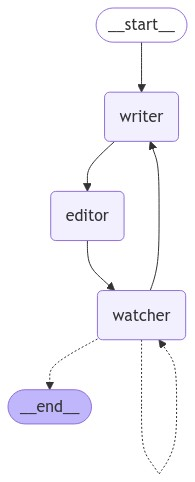

In [9]:
display(Image(app.get_graph().draw_mermaid_png()))